In [1]:
#knitr::opts_chunk$set(echo = TRUE)

# QC_sg

In this notebook, we perform QC for the Singaporean population only. Samples: sarcopenia vs healthy controls. 

In [2]:
suppressPackageStartupMessages({
    library(DESeq2)
    library(ggrepel)
    library(genefilter)
    library(GenomicFeatures)
    library(biomaRt)
    library(reshape2)
    library(scales)
    library(Biostrings)
    library(tidyverse)
    library(janitor)
    library(DT)
    library(pheatmap)
    library(clusterProfiler)
    library("org.Hs.eg.db")
    library(GEOquery)
    library(limma)
    library(sva)
})


In [3]:
### --- Get gene-level annotations (run once) --- ###

#hs.gtf.db <- makeTxDbFromGFF("../data/annotation/Homo_sapiens.GRCh38.94.chr.gtf", 
#                             format="gtf" )

#ensembl.genes = genes(hs.gtf.db)
#human = useEnsembl(biomart="ENSEMBL_MART_ENSEMBL", 
#                      dataset="hsapiens_gene_ensembl", mirror = "useast")
#bm.annotations = getBM(attributes=c("ensembl_gene_id", "entrezgene_id", "gene_biotype", "external_gene_name"), 
#                       mart=human, 
#                       filters="ensembl_gene_id", 
#                       values=ensembl.genes$gene_id, uniqueRows=TRUE)
#ensembl.genes$gene_biotype = bm.annotations$gene_biotype[match(ensembl.genes$gene_id, bm.annotations$ensembl_gene_id) ]
#ensembl.genes$entrezgene_id = bm.annotations$entrezgene_id[match(ensembl.genes$gene_id, bm.annotations$ensembl_gene_id) ]
#ensembl.genes$external_gene_name = bm.annotations$external_gene_name[match(ensembl.genes$gene_id, bm.annotations$ensembl_gene_id) ]

# save this as RDS so we don't have to keep running it
#saveRDS(bm.annotations, file = "../../output/bm_annotations.RDS")
#saveRDS(ensembl.genes, file = "../../output/ensembl.genes.RDS")

In [4]:
### -- Get metadata (run once) --- ###  

#Get series matrix files that contain the metadata
#sg_geo <- GEOquery::getGEO(filename = "../data/metadata/GSE111016_series_matrix.txt")
#jm_geo <- GEOquery::getGEO(filename = "../data/metadata/GSE111010_series_matrix.txt")

# Extract the metadata
#sg_geo_md <- pData(phenoData(sg_geo)) %>% clean_names()
#jm_geo_md <- pData(phenoData(jm_geo)) %>% clean_names()

#write_delim(sg_geo_md, file = "../../data/metadata/sg_geo_md.txt")
#write_delim(jm_geo_md, file = "../../data/metadata/jm_geo_md.txt")

## Read in files

In [5]:
bm.annotations <- readRDS("../../data/bm_annotations.RDS")
ensembl.genes <- readRDS("../../data/ensembl.genes.RDS")

sg_geo_md <- read_delim(file = "../../data/metadata/sg_geo_md.txt")

Rows: 40 Columns: 48
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (43): title, geo_accession, status, submission_date, last_update_date, t...
dbl  (5): channel_count, taxid_ch1, contact_zip_postal_code, data_row_count,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
### --- Clean and combine metadata --- ### 

# Subset columns of interest
sg_md <- sg_geo_md %>% 
    dplyr::select(title, sex_ch1, age_yr_ch1, 
                  population_ch1, sarcopenia_status_ch1, tissue_ch1) %>% 
    rename(sample_id = title)
colnames(sg_md) <- gsub("_ch1", "", colnames(sg_md))

# Change Sample 1 [sss] to sample_1
sg_md$sample_id <- gsub(" \\[sss]", "", sg_md$sample_id)
sg_md$sample_id <- gsub(" ", "_", sg_md$sample_id)
sg_md$sample_id <- gsub("Sample", "sg_sample", sg_md$sample_id)
sg_md$country <- "sg"

# Combine the jamaica and sg metadata
metadata <- sg_md
# get sarco and control
metadata$condition = ifelse(metadata$sarcopenia_status == "yes", "sarco", "ctrl")
# Change sg_sample_1 to sg_sarco_1, number it according to group
metadata <- metadata %>% 
    group_by(sarcopenia_status, country) %>% 
    mutate(sample_no = 1:n()) %>% 
    arrange(condition) %>% 
    unite("sample_id_new", country:sample_no, sep = "_", remove = FALSE)

metadata$country <- as.factor(metadata$country)
metadata$condition <- factor(metadata$condition, levels = c("ctrl", "sarco"))

head(metadata)

sample_id,sex,age_yr,population,sarcopenia_status,tissue,sample_id_new,country,condition,sample_no
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<int>
sg_sample_1,male,69,Chinese descent,no,vastus lateralis muscle,sg_ctrl_1,sg,ctrl,1
sg_sample_2,male,69,Chinese descent,no,vastus lateralis muscle,sg_ctrl_2,sg,ctrl,2
sg_sample_5,male,71,Chinese descent,no,vastus lateralis muscle,sg_ctrl_3,sg,ctrl,3
sg_sample_6,male,65,Chinese descent,no,vastus lateralis muscle,sg_ctrl_4,sg,ctrl,4
sg_sample_9,male,71,Chinese descent,no,vastus lateralis muscle,sg_ctrl_5,sg,ctrl,5
sg_sample_10,male,67,Chinese descent,no,vastus lateralis muscle,sg_ctrl_6,sg,ctrl,6


In [7]:
### --- Create data matrix --- ###

sg <- read.csv(
    file = "../../data/data_raw/GSE111016_allSamplesCounts_htseqcov1_sss_forGEO.csv") %>% 
    janitor::clean_names()
# Add gene names to rownames
rownames(sg) <- sg$x
# Remove the x column (ensembl gene id)
sg <- sg[ ,!colnames(sg) == "x"]
# Add prefix, rename colnames
colnames(sg) <- paste0("sg_", colnames(sg))
colnames(sg) <- metadata$sample_id_new[match(colnames(sg), metadata$sample_id)]
sg$ensembl_gene_id = rownames(sg)

# Join the counts matrix, remove ensembl_gene_id column
counts <- sg  %>% 
            dplyr::select("ensembl_gene_id", metadata$sample_id_new)
counts[is.na(counts)] <- 0
remove = "ensembl_gene_id"
data_mat = as.matrix(counts[, !colnames(counts) %in% remove])
rownames(data_mat) = counts$ensembl_gene_id

# Keep only rows that start with ENSG (remove the __nofeature rows)
#data_mat <- data_mat[rownames(data_mat)[grep("^ENSG", rownames(data_mat))], ]
data_mat = apply(round(data_mat), c(1,2), as.integer) # Round to integer
data_mat_nonzero = data_mat[rowSums(data_mat) > 0, ] # Rm non-zero rows


sum(duplicated(rownames(data_mat_nonzero)))# Check that we have no duplicates

[1] 0

In [8]:
# Check that all rows start with ENSG; that is, no rows do not start with ENSG:
data_mat[rownames(data_mat)[grep("^ENSG", rownames(data_mat), invert = TRUE)], ]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


sg_ctrl_1,sg_ctrl_2,sg_ctrl_3,sg_ctrl_4,sg_ctrl_5,sg_ctrl_6,sg_ctrl_7,sg_ctrl_8,sg_ctrl_9,sg_ctrl_10,⋯,sg_sarco_11,sg_sarco_12,sg_sarco_13,sg_sarco_14,sg_sarco_15,sg_sarco_16,sg_sarco_17,sg_sarco_18,sg_sarco_19,sg_sarco_20


In [9]:
nrow(data_mat)

[1] 65217

In [10]:
nrow(data_mat_nonzero)

[1] 53229

In [11]:
nrow(data_mat_nonzero)/nrow(data_mat) * 100

[1] 81.61829

In [12]:
#Creates the DESeq2 object
# Run it first without controlling for age
dds = DESeqDataSetFromMatrix(data_mat_nonzero, metadata, 
                             ~ condition)
colnames(dds) = colnames(data_mat)

#Estimates the size factors using the "median ratio method" described by Equation 5 in Anders and Huber (2010)
dds <- estimateSizeFactors(dds) 

#This function obtains dispersion estimates for a count data set
dds <- estimateDispersions(dds)

#This function transforms the count data to the log2 scale in a way which minimizes differences between samples for rows with small counts
rld <- vst(dds)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



## Global theme options

In [13]:
# Generic theme
th <- theme(axis.text.x = element_text(size = 15),
          axis.text.y = element_text(size = 15),
         plot.title = element_text(size = 20),
         plot.subtitle = element_text(size = 15),
         axis.title.x = element_blank(),
         axis.title.y = element_blank())

In [14]:
# pca theme
pca_th <- theme(plot.title = element_text(size = 20),
         axis.title.x = element_text(size = 15), 
         axis.title.y = element_text(size = 15),
         axis.text.x = element_text(size = 15),
         axis.text.y = element_text(size = 15))

## Analysis

### Sample clustering

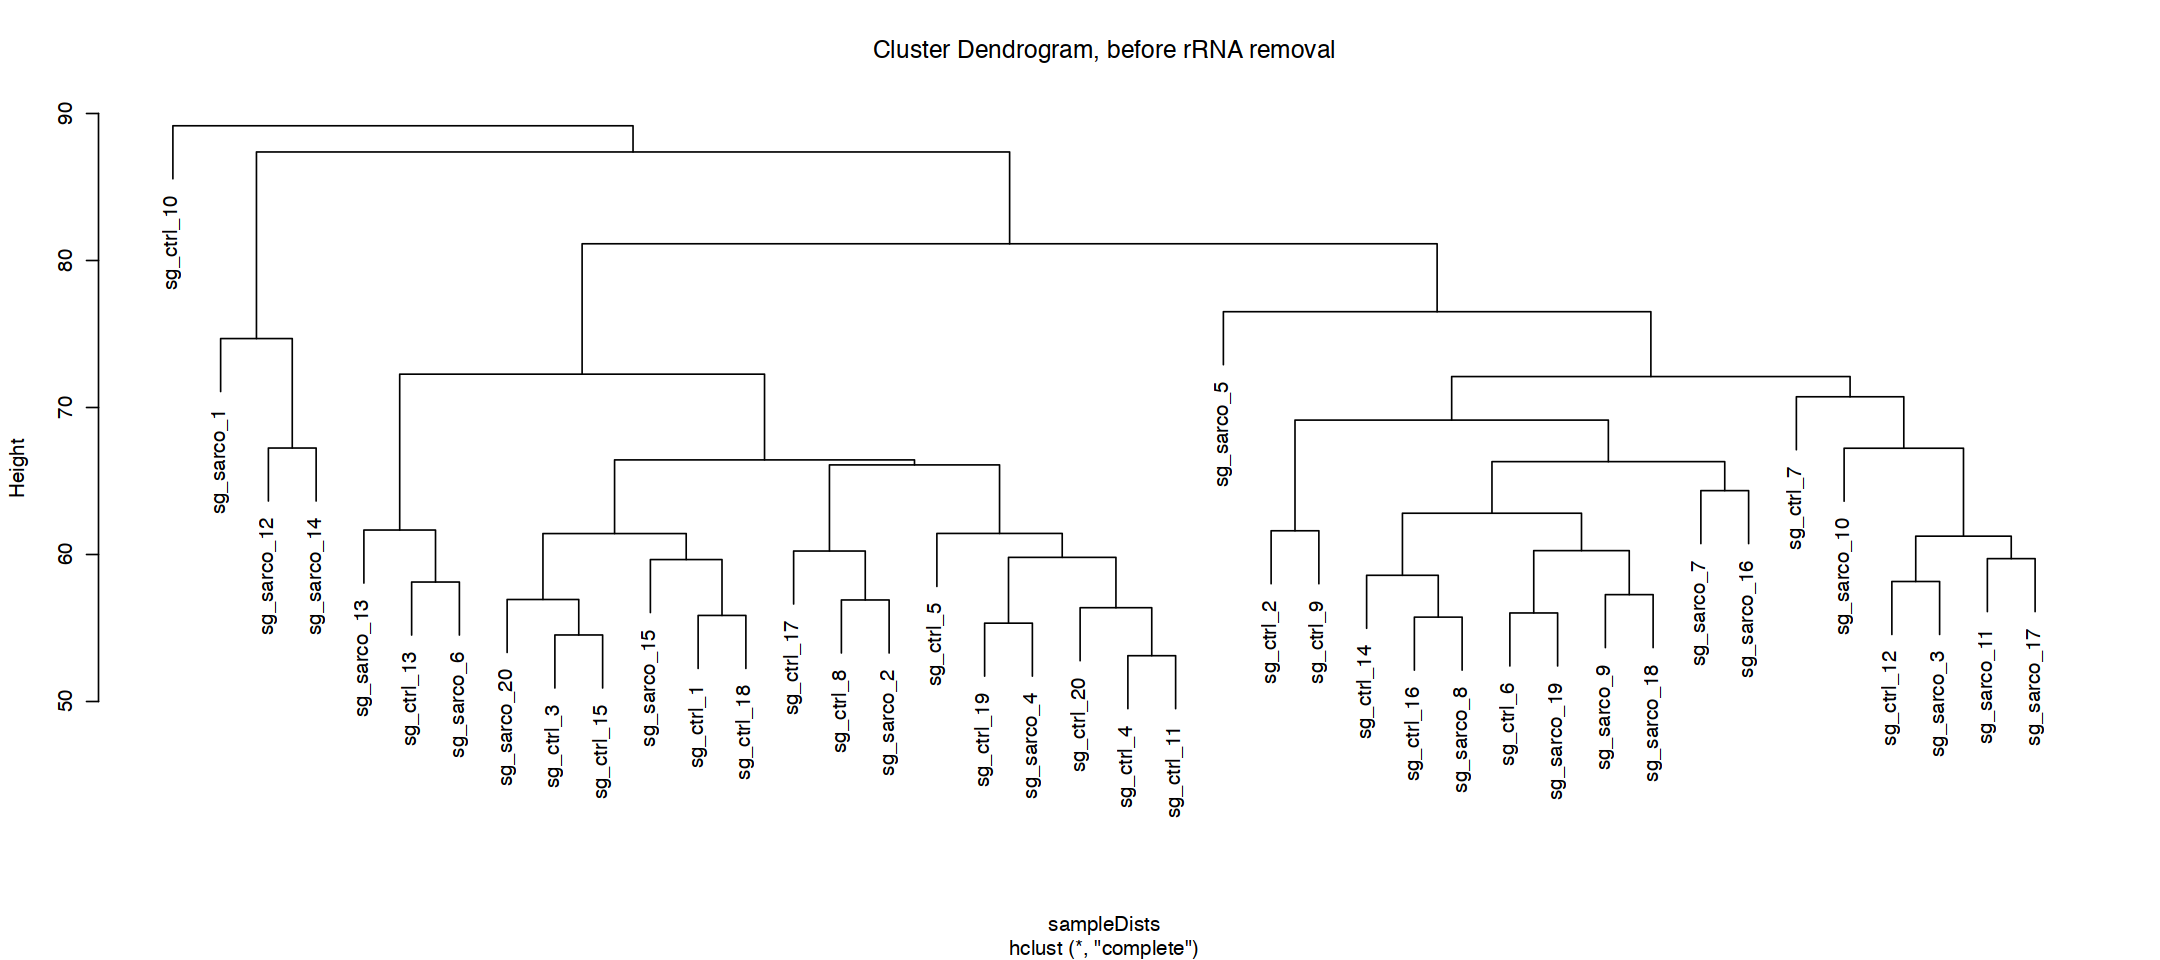

In [15]:
options(repr.plot.height = 8, repr.plot.width = 18)

sampleDists <- dist(t(assay(rld)))
plot(hclust(sampleDists), main = "Cluster Dendrogram, before rRNA removal")

### PCA

In [16]:
ntop = 500
rv <- rowVars(assay(rld))
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
pca = prcomp(t(assay(rld)[select,]))
percentVar <- pca$sdev^2/sum(pca$sdev^2)

set.seed(1)
pca_data <- plotPCA(rld, intgroup = c("condition"), returnData=TRUE)
percentVar <- round(100 * attr(pca_data, "percentVar"), digits=2)

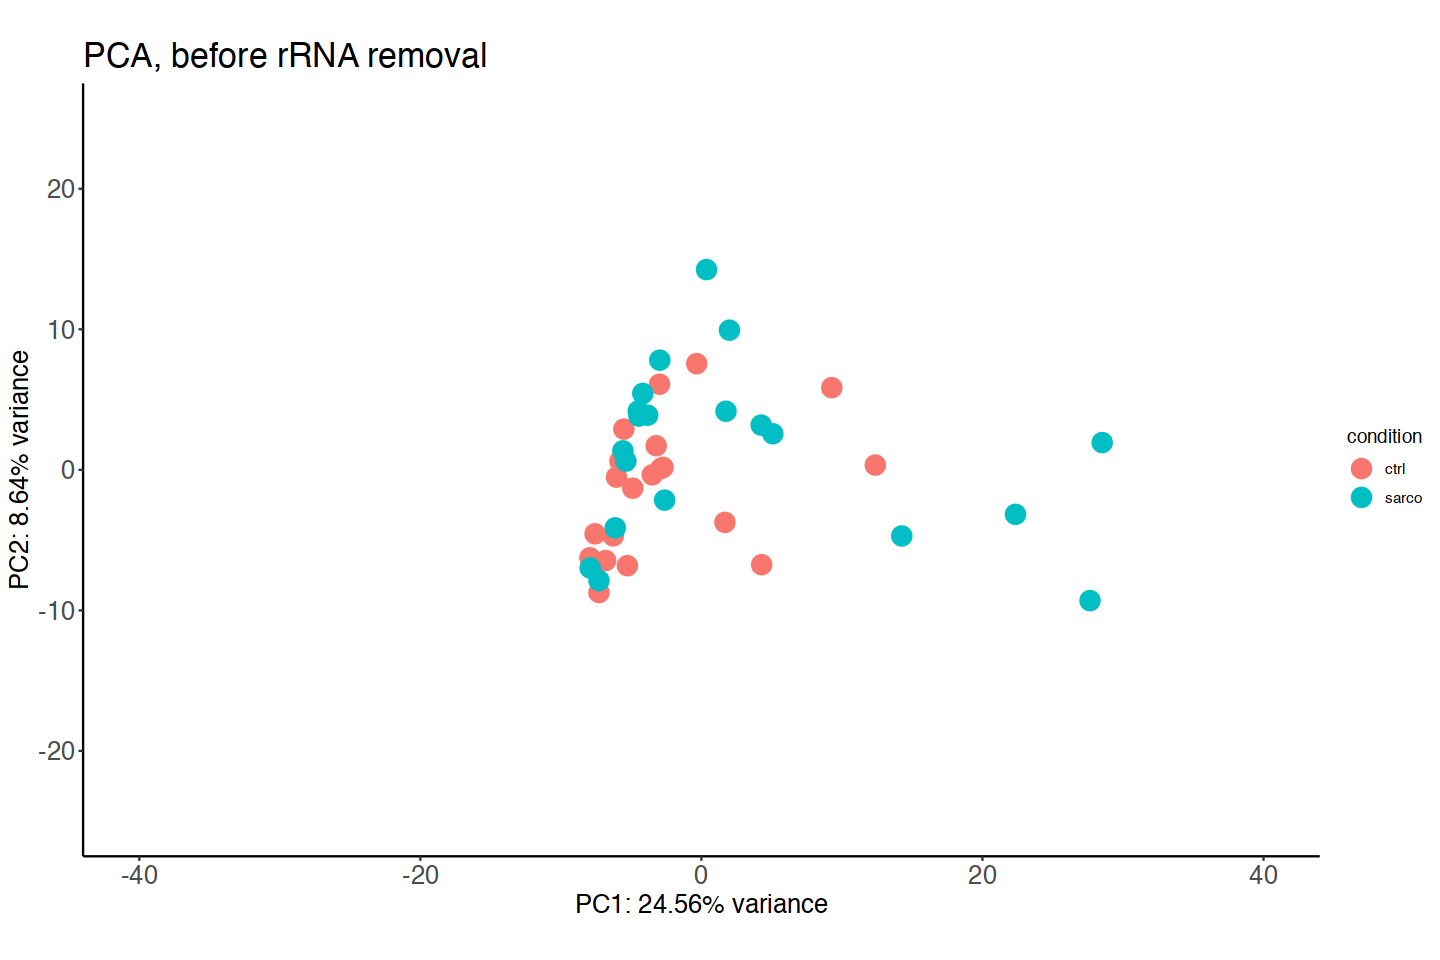

In [17]:
options(repr.plot.height = 8, repr.plot.width = 12)

ggplot(pca_data, aes(PC1, PC2, color=condition)) + geom_point(size=5) +
  scale_x_continuous(paste0("PC1: ",percentVar[1],"% variance"),
                    limits = c(-40, 40)) +
  scale_y_continuous(paste0("PC2: ",percentVar[2],"% variance"),
                    limits = c(-25, 25)) + 
  coord_fixed() + 
  theme_classic() + 
  #geom_text_repel(data = pca_data, aes(PC1,PC2, label = name), 
  #                hjust = 1.2, box.padding = 0.5, size = 5.5) +
  expand_limits(x = c(-50, 50), y = c(-30, 30)) +
  labs(title = "PCA, before rRNA removal") +
  pca_th

### Number of genes detected

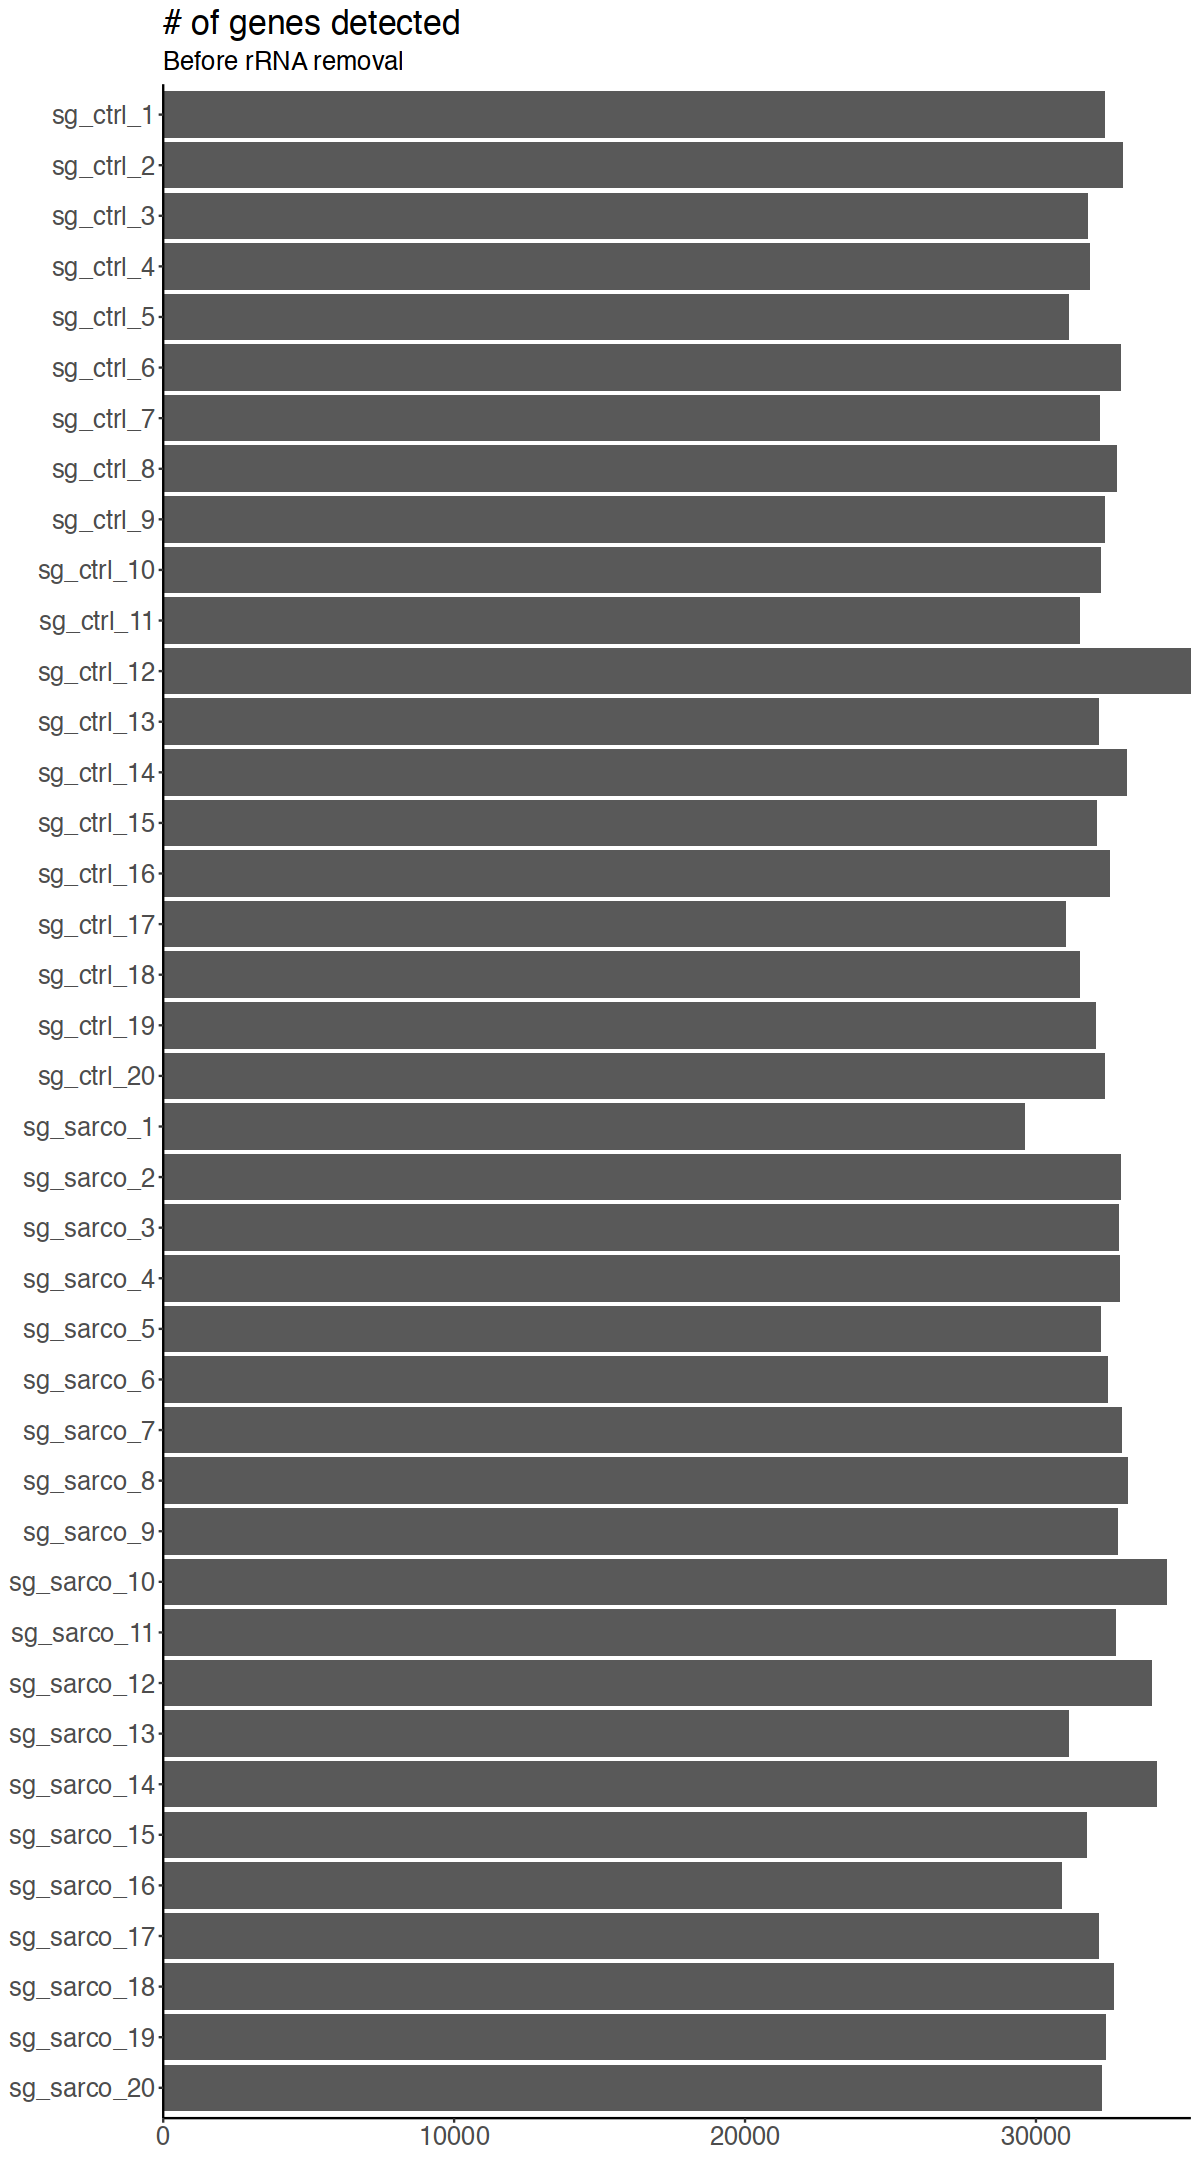

In [18]:
options(repr.plot.height = 18, repr.plot.width = 10)

detected = apply(counts(dds), 2, function(col) sum(col > 0 ))
detected = as.data.frame(detected)
detected$name = row.names(detected)
detected$name = factor(detected$name, rev(metadata$sample_id_new))
                 
ggplot(detected, aes(x=name, y=detected)) + 
                 geom_bar(stat="identity") + 
                 theme_classic() + 
                 coord_flip() + 
                 scale_y_continuous("Number of Genes detected", expand=c(0,0)) + 
                 scale_x_discrete("Sample") +
                 labs(title = "# of genes detected", 
                     subtitle = "Before rRNA removal") +
                 th

### Normalised counts (boxplot)

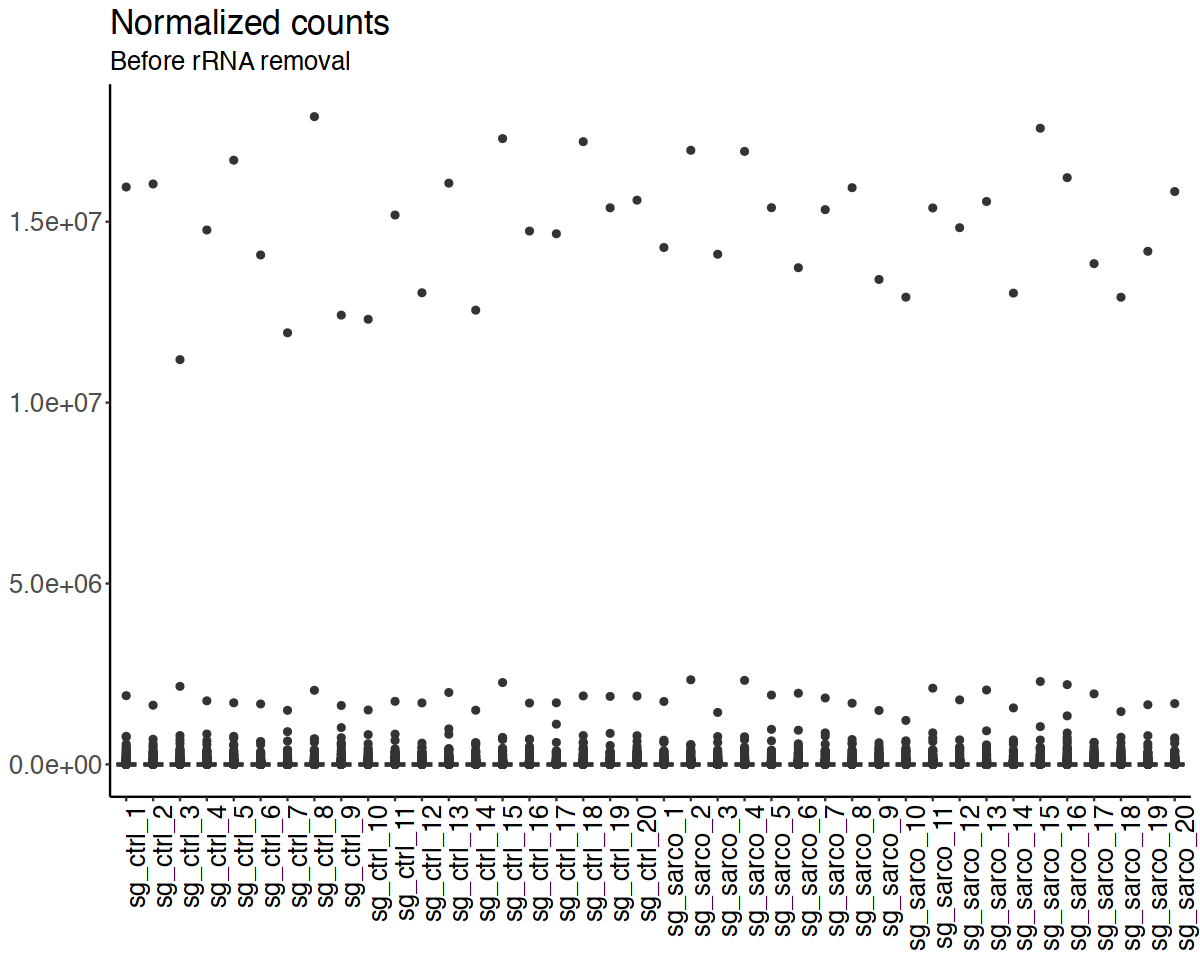

In [19]:
options(repr.plot.height = 8, repr.plot.width = 10)

nc = counts(dds, normalized=TRUE)
nc.melt = melt(nc)

ggplot(nc.melt, aes(x=Var2, y=value)) + 
    geom_boxplot() + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, colour="black", hjust = 1)) + 
    scale_x_discrete("Sample") + 
    scale_y_continuous("Normalised counts") +
    labs(title = "Normalized counts",
        subtitle = "Before rRNA removal") +
    th

In [20]:
nc.threshold = 1e6
test = apply(nc, 1, function(x){ any(x> nc.threshold) })

as.data.frame(ensembl.genes[names(test[test])])
 
#as.data.frame(ensembl.genes[names(test[test])]) %>%
#  kable %>% kable_styling("striped", full_width = F) %>% scroll_box(width = "800px", height = "500px")

,seqnames,start,end,width,strand,gene_id,gene_biotype,entrezgene_id,external_gene_name
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<chr>
ENSG00000125414,chr17,10521148,10549957,28810,-,ENSG00000125414,protein_coding,4620,MYH2
ENSG00000155657,chr2,178525989,178830802,304814,-,ENSG00000155657,protein_coding,7273,TTN
ENSG00000183091,chr2,151485336,151734487,249152,-,ENSG00000183091,protein_coding,4703,NEB
ENSG00000210082,chrM,1671,3229,1559,+,ENSG00000210082,Mt_rRNA,NA,MT-RNR2


This is a rRNA; we should remove it. 

### Normalised counts (Transcripts per million (TPM))

In [21]:
#options(repr.plot.height = 8, repr.plot.width = 10)

#effective_lengths = matrix(0, ncol=length(experimental_metadata$sample_id), nrow=17714)
#colnames(effective_lengths)= experimental_metadata$sample_id
#for( i in experimental_metadata$sample_id){
#  effective_lengths[,i] = read.table(paste("../data/aligned_data/", i, ".genes.results",sep=""), sep="\t", header=TRUE)$effective_length
#}
#row.names(effective_lengths) = read.table(paste("../data/aligned_data/", i, ".genes.results",sep=""), sep="\t", header=TRUE)$gene_id

#effective_lengths = rowMeans(effective_lengths[row.names(counts(dds)),])
#ncrpk = counts(dds) / (effective_lengths / 1000)
#ncrpk = apply(ncrpk, c(1,2), function(x){if(is.nan(x)){0}else{x}})
#ncrpk = apply(ncrpk, c(1,2), function(x){if(is.infinite(x)){0}else{x}})
#ncscalingfactor = colSums(ncrpk) / 1e6
#nctpm = sweep(ncrpk, 2, ncscalingfactor, "/")

#nctpm.melt = melt(nctpm)
#ggplot(nctpm.melt, aes(x=Var2, y=value)) + 
#    geom_boxplot() + 
#    theme_classic() + 
#    theme(axis.text.x = element_text(angle = 90, colour="black", hjust = 1)) + 
#    labs(title = "Normalized counts (TPM)", 
#        subtitle = "Before rRNA removal") +
#    th

In [22]:
#tpm.threshold = 20000
#test.tpm = apply(nctpm, 1, function(x){ any(x> tpm.threshold) })

#as.data.frame(ensembl.genes[names(test.tpm[test.tpm])]) #%>%
  #kable %>% kable_styling("striped", full_width = F) %>% scroll_box(width = "800px", height = "500px")

Most of these are protein-coding genes. However, there is one rRNA that should be removed. 

### rRNA percentage

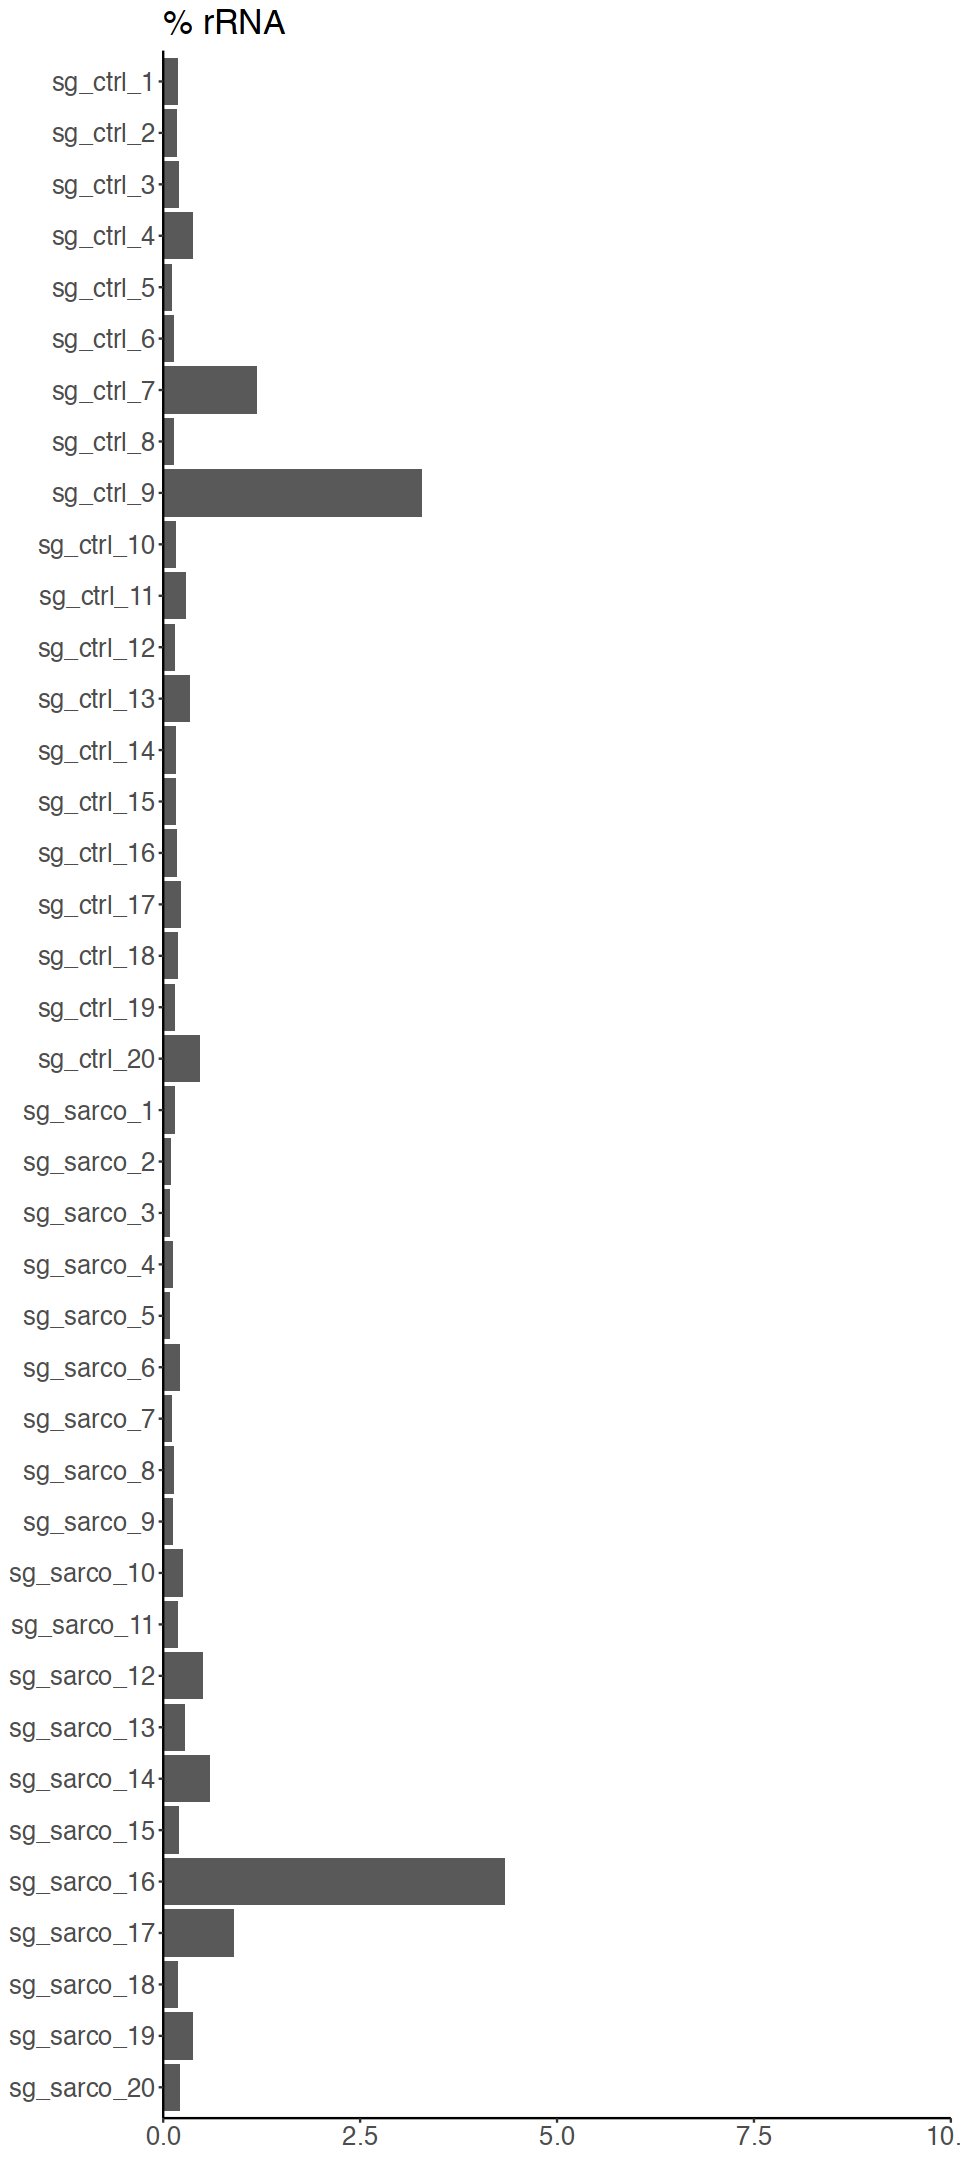

In [23]:
options(repr.plot.height = 18, repr.plot.width = 8)

rrna.genes = names(ensembl.genes[ensembl.genes$gene_biotype %in% c("Mt_rRNA", "rRNA")])
percentage.of.rrna = (colSums(counts(dds[ rownames(counts(dds)) %in% rrna.genes])) / colSums(counts(dds))) * 100

percentage.of.rrna = as.data.frame(percentage.of.rrna)
percentage.of.rrna$name = row.names(percentage.of.rrna)
percentage.of.rrna$name = factor(percentage.of.rrna$name,rev(metadata$sample_id_new))
ggplot(percentage.of.rrna, 
       aes(x=name, y=percentage.of.rrna)) + 
        geom_bar(stat="identity") + 
        theme_classic() + 
        coord_flip() + 
        th +
        scale_y_continuous("% rRNA", expand=c(0,0), limits = c(0, 10)) +
        labs(title = "% rRNA")


In [24]:
summary(percentage.of.rrna$percentage.of.rrna)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0829  0.1382  0.1839  0.4304  0.2969  4.3389 

Our samples have relatively low rRNA % - all of them are below 5%, which is reassuring. Still, these should be removed. 

### Proportions of gene biotypes

Using name as id variables



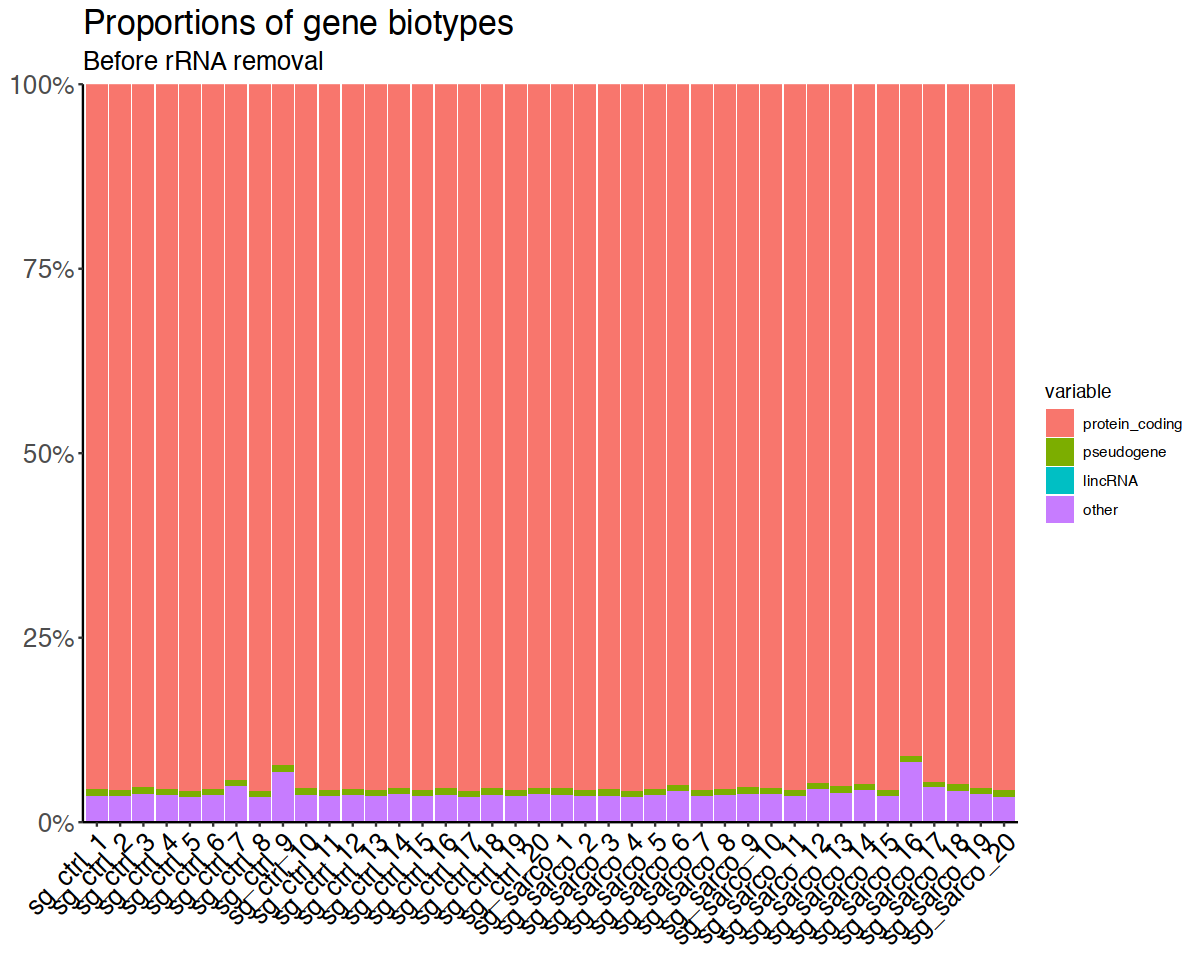

In [25]:
options(repr.plot.height = 6, repr.plot.width = 20)

pc = ensembl.genes$gene_id[ensembl.genes$gene_biotype == "protein_coding"]
pg = ensembl.genes$gene_id[ensembl.genes$gene_biotype %in% unique(ensembl.genes$gene_biotype)[grep("pseudogene", unique(ensembl.genes$gene_biotype))]]
lc = ensembl.genes$gene_id[ensembl.genes$gene_biotype == "lincRNA"]

totalcounts.pc = colSums(counts(dds)[rownames(counts(dds)) %in% pc,])
totalcounts.pg = colSums(counts(dds)[rownames(counts(dds)) %in% pg,])
totalcounts.lc = colSums(counts(dds)[rownames(counts(dds)) %in% lc,])

totalcounts.other = colSums(counts(dds)[!(rownames(counts(dds)) %in% c(lc,pc,pg)),])

counts.by.biotype = data.frame(name = names(totalcounts.pc),
                         protein_coding = totalcounts.pc,
                         pseudogene = totalcounts.pg,
                         lincRNA = totalcounts.lc,
                         other = totalcounts.other
                         
                         )

counts.by.biotype$name = factor(counts.by.biotype$name, metadata$sample_id_new)

counts.by.biotype = as.data.frame(t(apply(counts.by.biotype[,2:5], 1, function(x){ 100 * (x / sum(x)) }) ))
counts.by.biotype$name = names(totalcounts.pc)
counts.by.biotype$name = factor(counts.by.biotype$name, metadata$sample_id_new)

counts.by.biotype.melt = melt(counts.by.biotype)

options(repr.plot.height = 8, repr.plot.width = 10)

ggplot(counts.by.biotype.melt, aes(x=name, y=value, fill=variable)) +  
    geom_bar(stat="identity") + 
    theme_classic() + 
    scale_y_continuous("% reads", labels = dollar_format(suffix = "%", prefix = ""),  
                       expand=c(0,0)) + scale_x_discrete("Sample") + 
    theme(axis.text.x = element_text(angle = 45, colour="black", #family="Arial", 
                                     hjust = 1, size=8)) +
    labs(title = "Proportions of gene biotypes", 
        subtitle = "Before rRNA removal") +
    th

### Remove rRNA from the analysis

In [26]:
dds_filt = dds[!(row.names(counts(dds)) %in% 
            ensembl.genes$gene_id[ensembl.genes$gene_biotype 
                                  %in% c("rRNA", "snoRNA", "snRNA", "Mt_rRNA")]),]
dds_filt = dds_filt[rowSums(counts(dds_filt)) > 0,]

In [27]:
dim(dds)

[1] 53229    40

In [28]:
dim(dds_filt)

[1] 51347    40

### Check rRNA removed

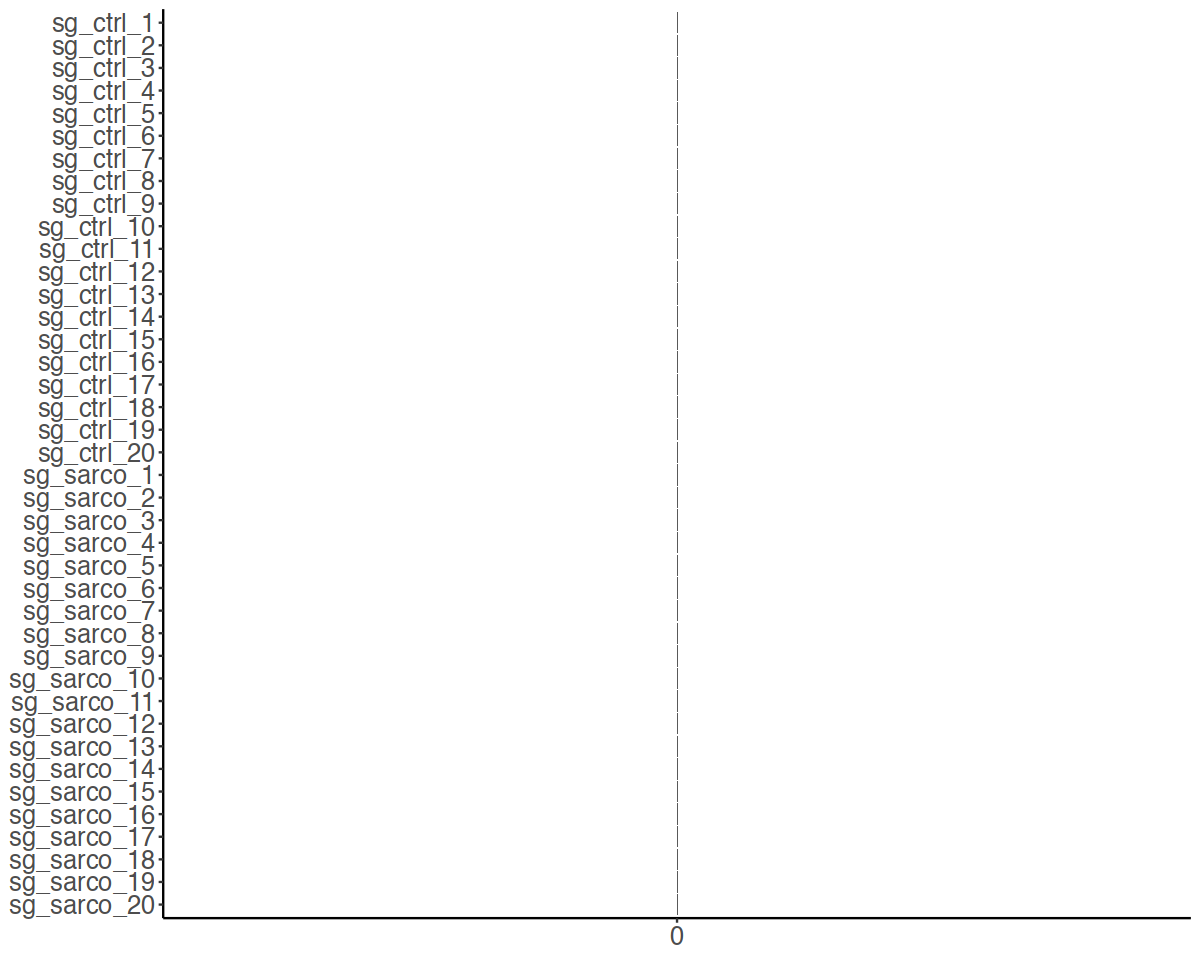

In [29]:
rrna.genes = names(ensembl.genes[ensembl.genes$gene_biotype %in% c("rRNA", "snoRNA", "snRNA", "Mt_rRNA")])
percentage.of.rrna = (colSums(counts(dds_filt[ rownames(counts(dds_filt)) %in% rrna.genes])) / 
                      colSums(counts(dds_filt))) * 100

percentage.of.rrna = as.data.frame(percentage.of.rrna)
percentage.of.rrna$name = row.names(percentage.of.rrna)
percentage.of.rrna$name = factor(percentage.of.rrna$name, rev(metadata$sample_id_new))
ggplot(percentage.of.rrna, aes(x=name, y=percentage.of.rrna)) + 
    geom_bar(stat="identity") + 
    theme_classic() + 
    coord_flip() + scale_y_continuous("% rRNA", expand=c(0,0)) + 
    scale_x_discrete("Sample") +
    th

### Check chrM intact

In [30]:
in_dds = ensembl.genes[which(rownames(dds_filt) %in% ensembl.genes$gene_id)]
table(seqnames(in_dds))


 chr1  chr2  chr3  chr4  chr5  chr6  chr7  chr8  chr9 chr10 chr11 chr12 chr13 
 4565  3490  2651  2262  2483  2455  2434  2020  1909  1889  2708  2348  1045 
chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22  chrX  chrY  chrM 
 1876  1727  2044  2388   927  2515  1156   632  1059  2086   460    37 

### Clustering after rRNA removal

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



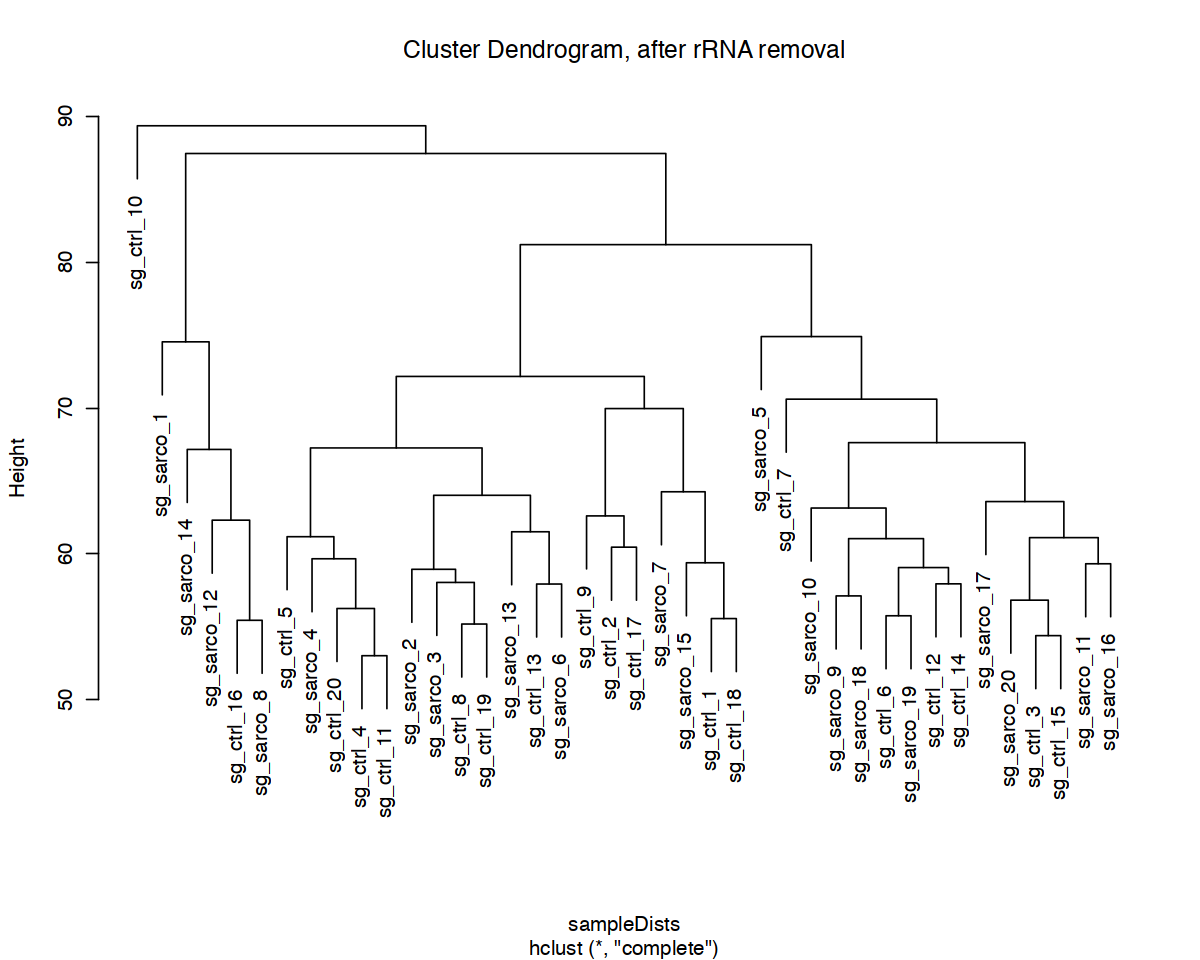

In [31]:
dds_filt <- estimateSizeFactors(dds_filt) 
dds_filt <- estimateDispersions(dds_filt)
rld_filt <- vst(dds_filt)

sampleDists <- dist(t(assay(rld_filt)))
plot(hclust(sampleDists), main = "Cluster Dendrogram, after rRNA removal")

### PCA after rRNA removal

In [32]:
ntop = 500
rv <- rowVars(assay(rld_filt))
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
pca = prcomp(t(assay(rld_filt)[select,]))
percentVar <- pca$sdev^2/sum(pca$sdev^2)

pca_data <- plotPCA(rld_filt, intgroup = c("condition"), returnData=TRUE)
percentVar <- round(100 * attr(pca_data, "percentVar"), digits=2)

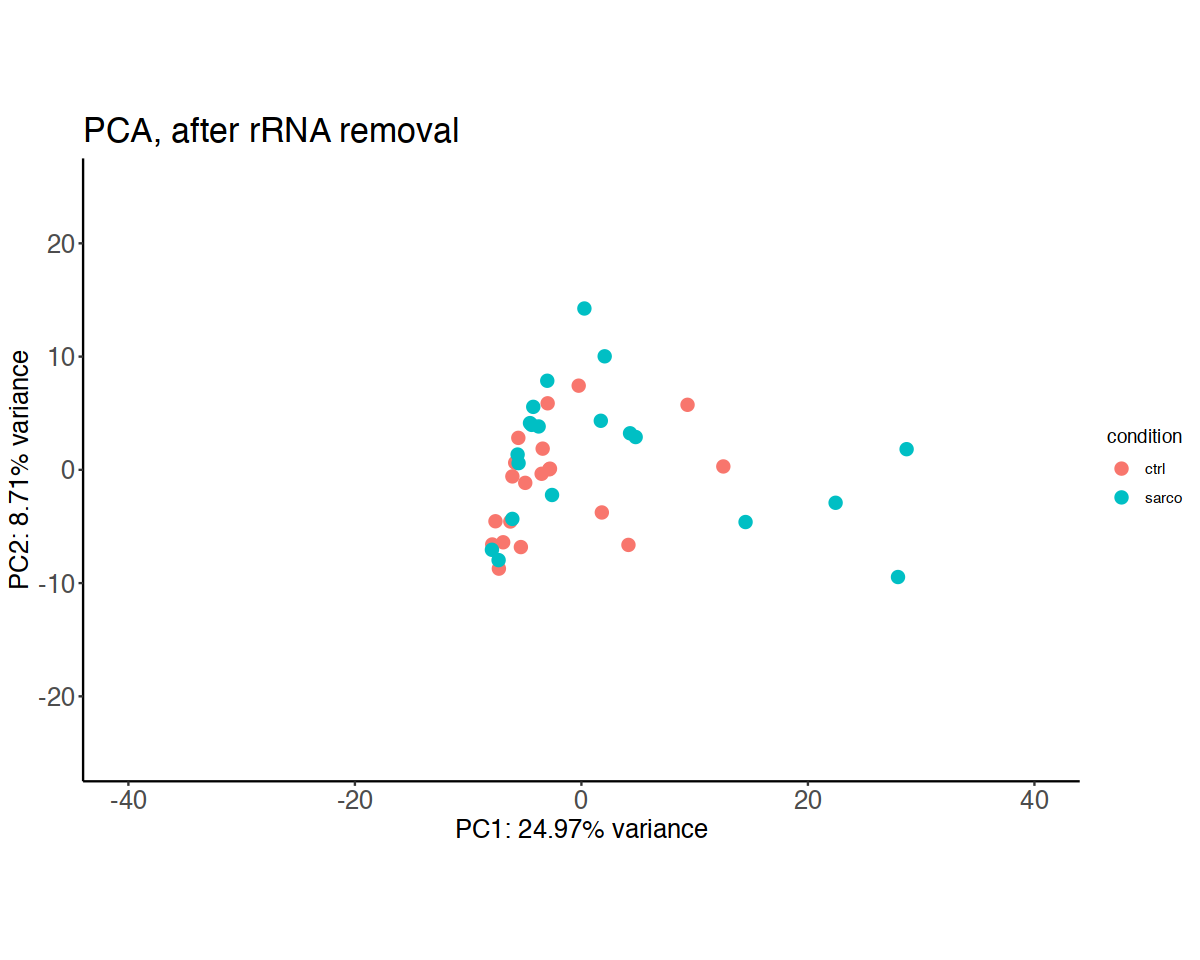

In [33]:
options(repr.plot.height = 8, repr.plot.width = 10)

ggplot(pca_data, aes(PC1, PC2, color=condition)) + 
 geom_point(size=3) +
  scale_x_continuous(paste0("PC1: ",percentVar[1],"% variance"),
                    limits = c(-40, 40)) +
  scale_y_continuous(paste0("PC2: ",percentVar[2],"% variance"),
                    limits = c(-25, 25)) + 
  coord_fixed() + theme_classic() + 
  #geom_text_repel(data = pca_data, aes(PC1,PC2, label = name), 
  #                hjust = 1.2, size = 5) +
    labs(title = "PCA, after rRNA removal") +
    pca_th

### Size Factors

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5690  0.9481  1.0504  1.0162  1.0918  1.2313 

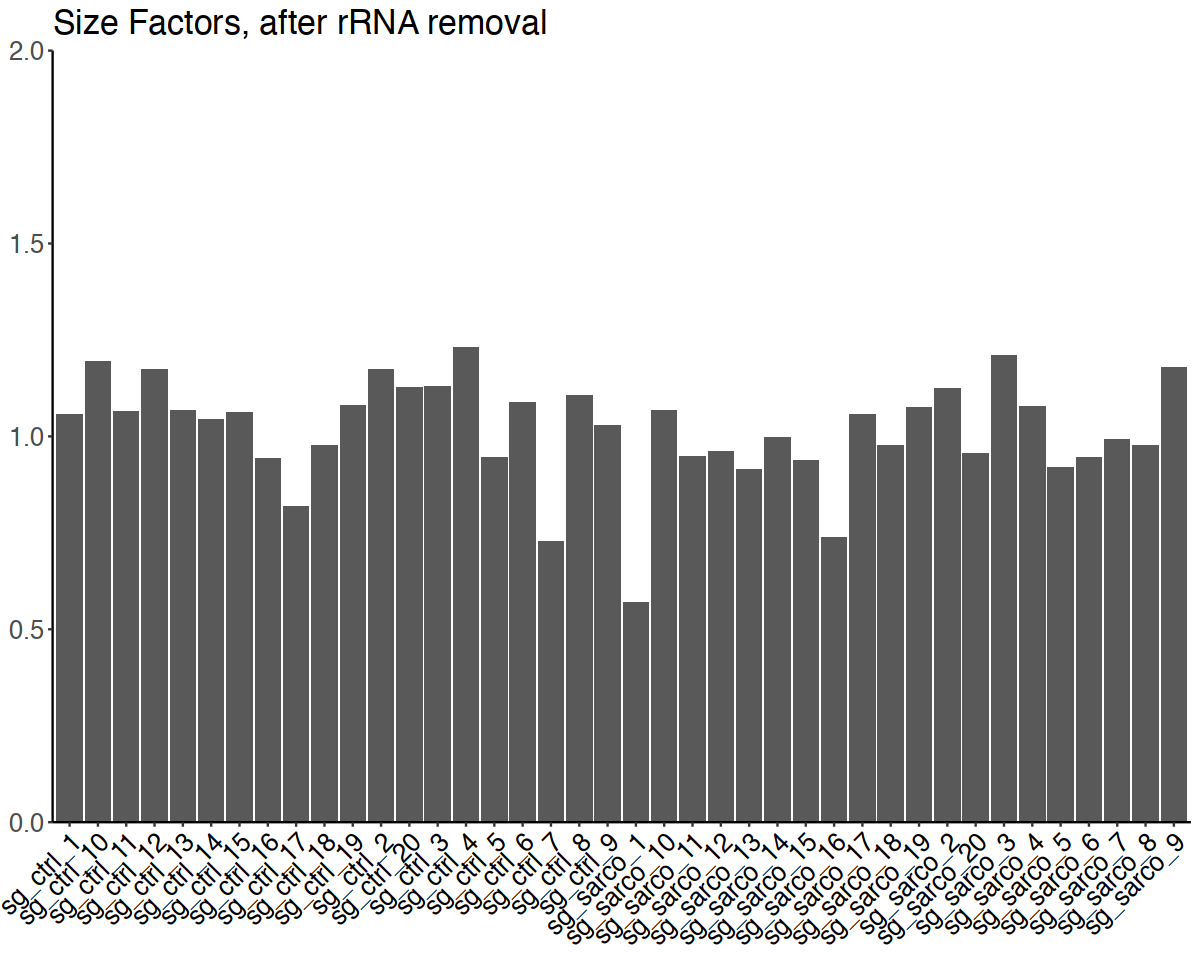

In [34]:
summary(sizeFactors(dds_filt))
df = data.frame(sample_id = names(sizeFactors(dds_filt)), 
                sizeFactors = sizeFactors(dds_filt))

ggplot(df, aes(x = sample_id, y=sizeFactors)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(limits=c(0,2), expand=c(0,0)) + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 45, hjust=1, colour="black", 
                                     #family="Arial",
                                     size=12)) +
    th +
    labs(title = "Size Factors, after rRNA removal")

### MA Plots

In [35]:
#for(cd in unique(experimental_metadata$condition)){
#  samples = experimental_metadata$sample_id[experimental_metadata$condition == cd]
#  for(i in 1:(length(samples)-1)){
#      print(i)
#      for(j in (i+1):(length(samples))){
#        print(j)
        
#        x = counts(dds, normalized=TRUE)[, samples[i]]
#        y = counts(dds, normalized=TRUE)[, samples[j]]
      
#        M = log2(x) - log2(y)
#        A = (log2(x) + log2(y)) / 2
#        df = data.frame(gene_id = names(x), M=M, A=A)
      
#        print(ggplot(df, aes(x=A, y=M)) + geom_point(size = 1.5, alpha = 1/5) + theme_classic() + geom_hline(yintercept=0, colour="blue3", linetype="dashed") + ggtitle(paste(samples[i], "vs", samples[j],  median(abs(x-y)), sep= " ")) + stat_smooth(se = FALSE, method = "loess", color = "red3") + theme_classic())
#    }
#  }
#}

### Normalised counts after removal of rRNA (boxplot)

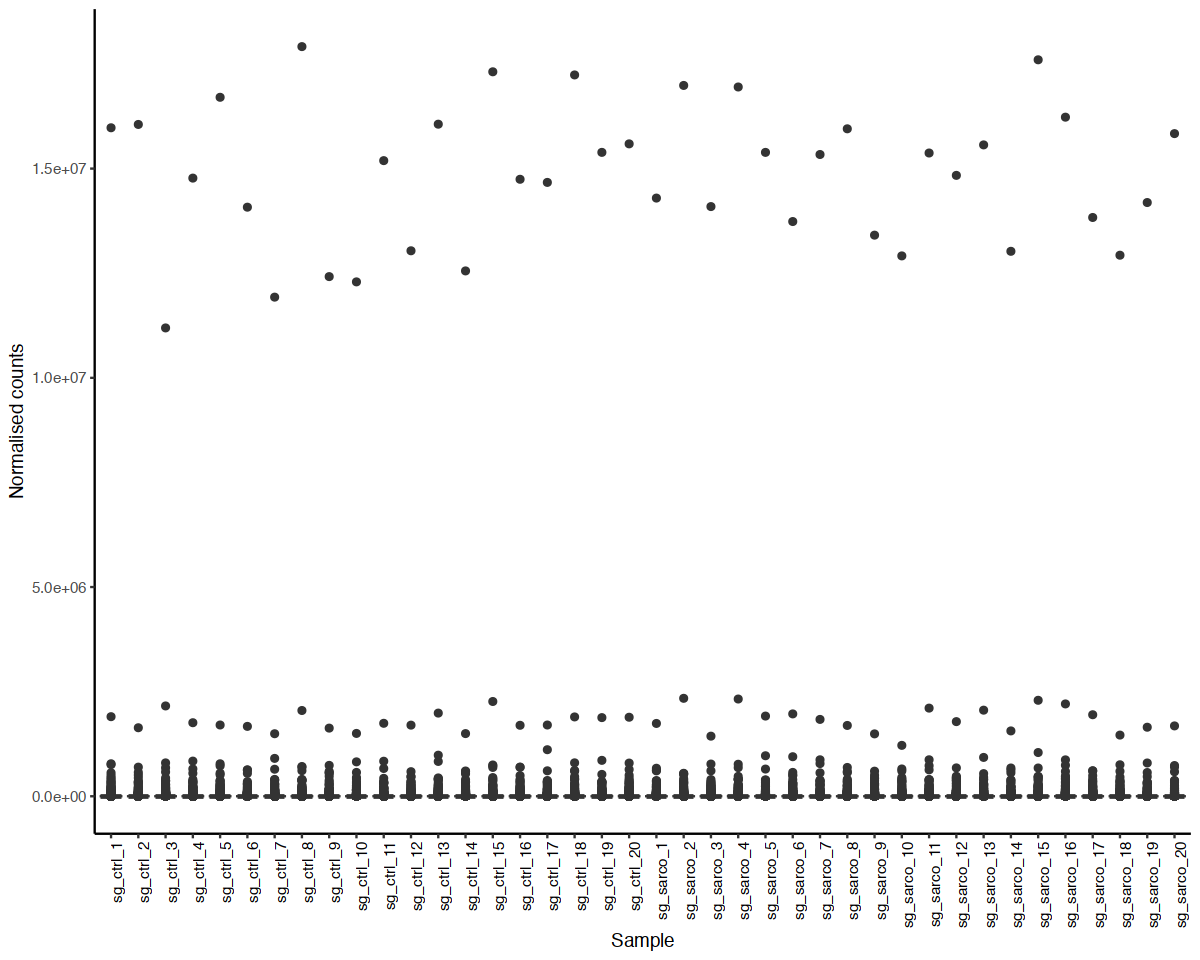

In [36]:
nc = counts(dds_filt, normalized=TRUE)
nc.melt = melt(nc)

ggplot(nc.melt, aes(x=Var2, y=value)) + 
    geom_boxplot() + theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, colour="black", hjust = 1)) + 
    scale_x_discrete("Sample") + scale_y_continuous("Normalised counts")

In [37]:
nc.threshold = 500000
test = apply(nc, 1, function(x){ any(x > nc.threshold) })
 
as.data.frame(ensembl.genes[names(test[test])]) #%>%
  #kable %>% kable_styling("striped", full_width = F) %>% scroll_box(width = "800px", height = "500px")

,seqnames,start,end,width,strand,gene_id,gene_biotype,entrezgene_id,external_gene_name
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<chr>
ENSG00000092054,chr14,23412738,23435718,22981,-,ENSG00000092054,protein_coding,4625,MYH7
ENSG00000104879,chr19,45306414,45322977,16564,-,ENSG00000104879,protein_coding,1158,CKM
ENSG00000125414,chr17,10521148,10549957,28810,-,ENSG00000125414,protein_coding,4620,MYH2
ENSG00000143632,chr1,229431245,229434098,2854,-,ENSG00000143632,protein_coding,58,ACTA1
ENSG00000155657,chr2,178525989,178830802,304814,-,ENSG00000155657,protein_coding,7273,TTN
ENSG00000183091,chr2,151485336,151734487,249152,-,ENSG00000183091,protein_coding,4703,NEB
ENSG00000198804,chrM,5904,7445,1542,+,ENSG00000198804,protein_coding,4512,MT-CO1


All of these are protein_coding genes; we can keep them. 

### Normalised counts after removal of rRNA (Transcripts per million (TPM)) 

In [38]:
#effective_lengths = matrix(0, ncol=length(experimental_metadata$sample_id), nrow=17714)
#colnames(effective_lengths)= experimental_metadata$sample_id
#for( i in experimental_metadata$sample_id){
#  effective_lengths[,i] = read.table(paste("../data/aligned_data/", i, ".genes.results",sep=""), sep="\t", header=TRUE)$effective_length
#}
#row.names(effective_lengths) = read.table(paste("../data/aligned_data/", i, ".genes.results",sep=""), sep="\t", header=TRUE)$gene_id

#effective_lengths = rowMeans(effective_lengths[row.names(counts(dds)),])
#ncrpk = counts(dds) / (effective_lengths / 1000)
#ncrpk = apply(ncrpk, c(1,2), function(x){if(is.nan(x)){0}else{x}})
#ncrpk = apply(ncrpk, c(1,2), function(x){if(is.infinite(x)){0}else{x}})
#ncscalingfactor = colSums(ncrpk) / 1e6
#nctpm = sweep(ncrpk, 2, ncscalingfactor, "/")

#nctpm.melt = melt(nctpm)
#ggplot(nctpm.melt, aes(x=Var2, y=value)) + geom_boxplot() + theme_classic() + theme(axis.text.x = element_text(angle = 90, colour="black", hjust = 1)) + scale_x_discrete("Sample") + scale_y_continuous("TPM")

In [39]:
#tpm.threshold = 10000
#test.tpm = apply(nctpm, 1, function(x){ any(x> tpm.threshold) })

#as.data.frame(ensembl.genes[names(test.tpm[test.tpm])]) #%>%
 # kable %>% kable_styling("striped", full_width = F) %>% scroll_box(width = "800px", height = "500px")
    

These all seem to be protein-coding genes, so we will not remove them.

# Batch correction

Next, we perform batch correction to remove the effects of age. 

# DESeq

In [40]:
dds_corrected <- dds_filt 
design(dds_corrected) <- formula(~ age_yr + condition)

dds_corrected <- DESeq(dds_corrected)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [41]:
rld_corrected <- vst(dds_corrected)

# Remove batch effect from country and year
assay(rld_corrected) <- limma::removeBatchEffect(assay(rld_corrected), 
                                                batch = metadata$age_yr)

## PCA

In [42]:
ntop = 500
rv <- rowVars(assay(rld_corrected))
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
pca = prcomp(t(assay(rld_corrected)[select,]))
percentVar <- pca$sdev^2/sum(pca$sdev^2)

pca_data <- plotPCA(rld_corrected, intgroup = c("age_yr", "country", "condition"), returnData=TRUE)
percentVar <- round(100 * attr(pca_data, "percentVar"), digits=2)

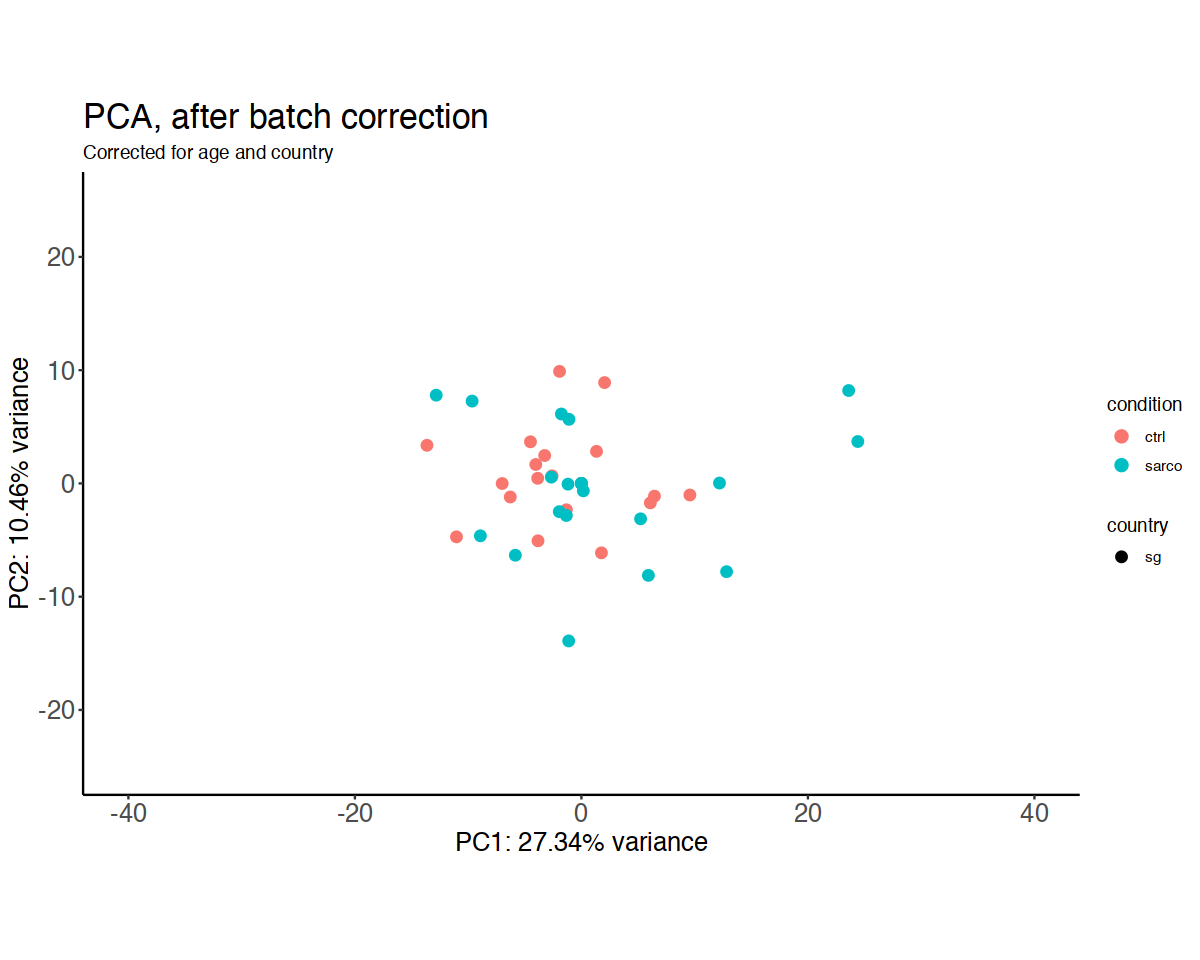

In [43]:
options(repr.plot.height = 8, repr.plot.width = 10)

pca_corrected <- ggplot(pca_data, aes(PC1, PC2, color = condition, shape=country)) + 
 geom_point(size=3) +
  scale_x_continuous(paste0("PC1: ",percentVar[1],"% variance"),
                    limits = c(-40, 40)) +
  scale_y_continuous(paste0("PC2: ",percentVar[2],"% variance"),
                    limits = c(-25, 25)) + 
  coord_fixed() + theme_classic() + 
  #geom_text_repel(data = pca_data, aes(PC1,PC2, label = name), 
  #                hjust = 1.2, size = 5) +
    labs(title = "PCA, after batch correction",
        subtitle = "Corrected for age and country") +
    pca_th

pca_corrected

Well, they've all (unsurprisingly) clustered closer together - however, there is still no clear separatio between controls and sarcopenia. 

## Hierarchical clustering

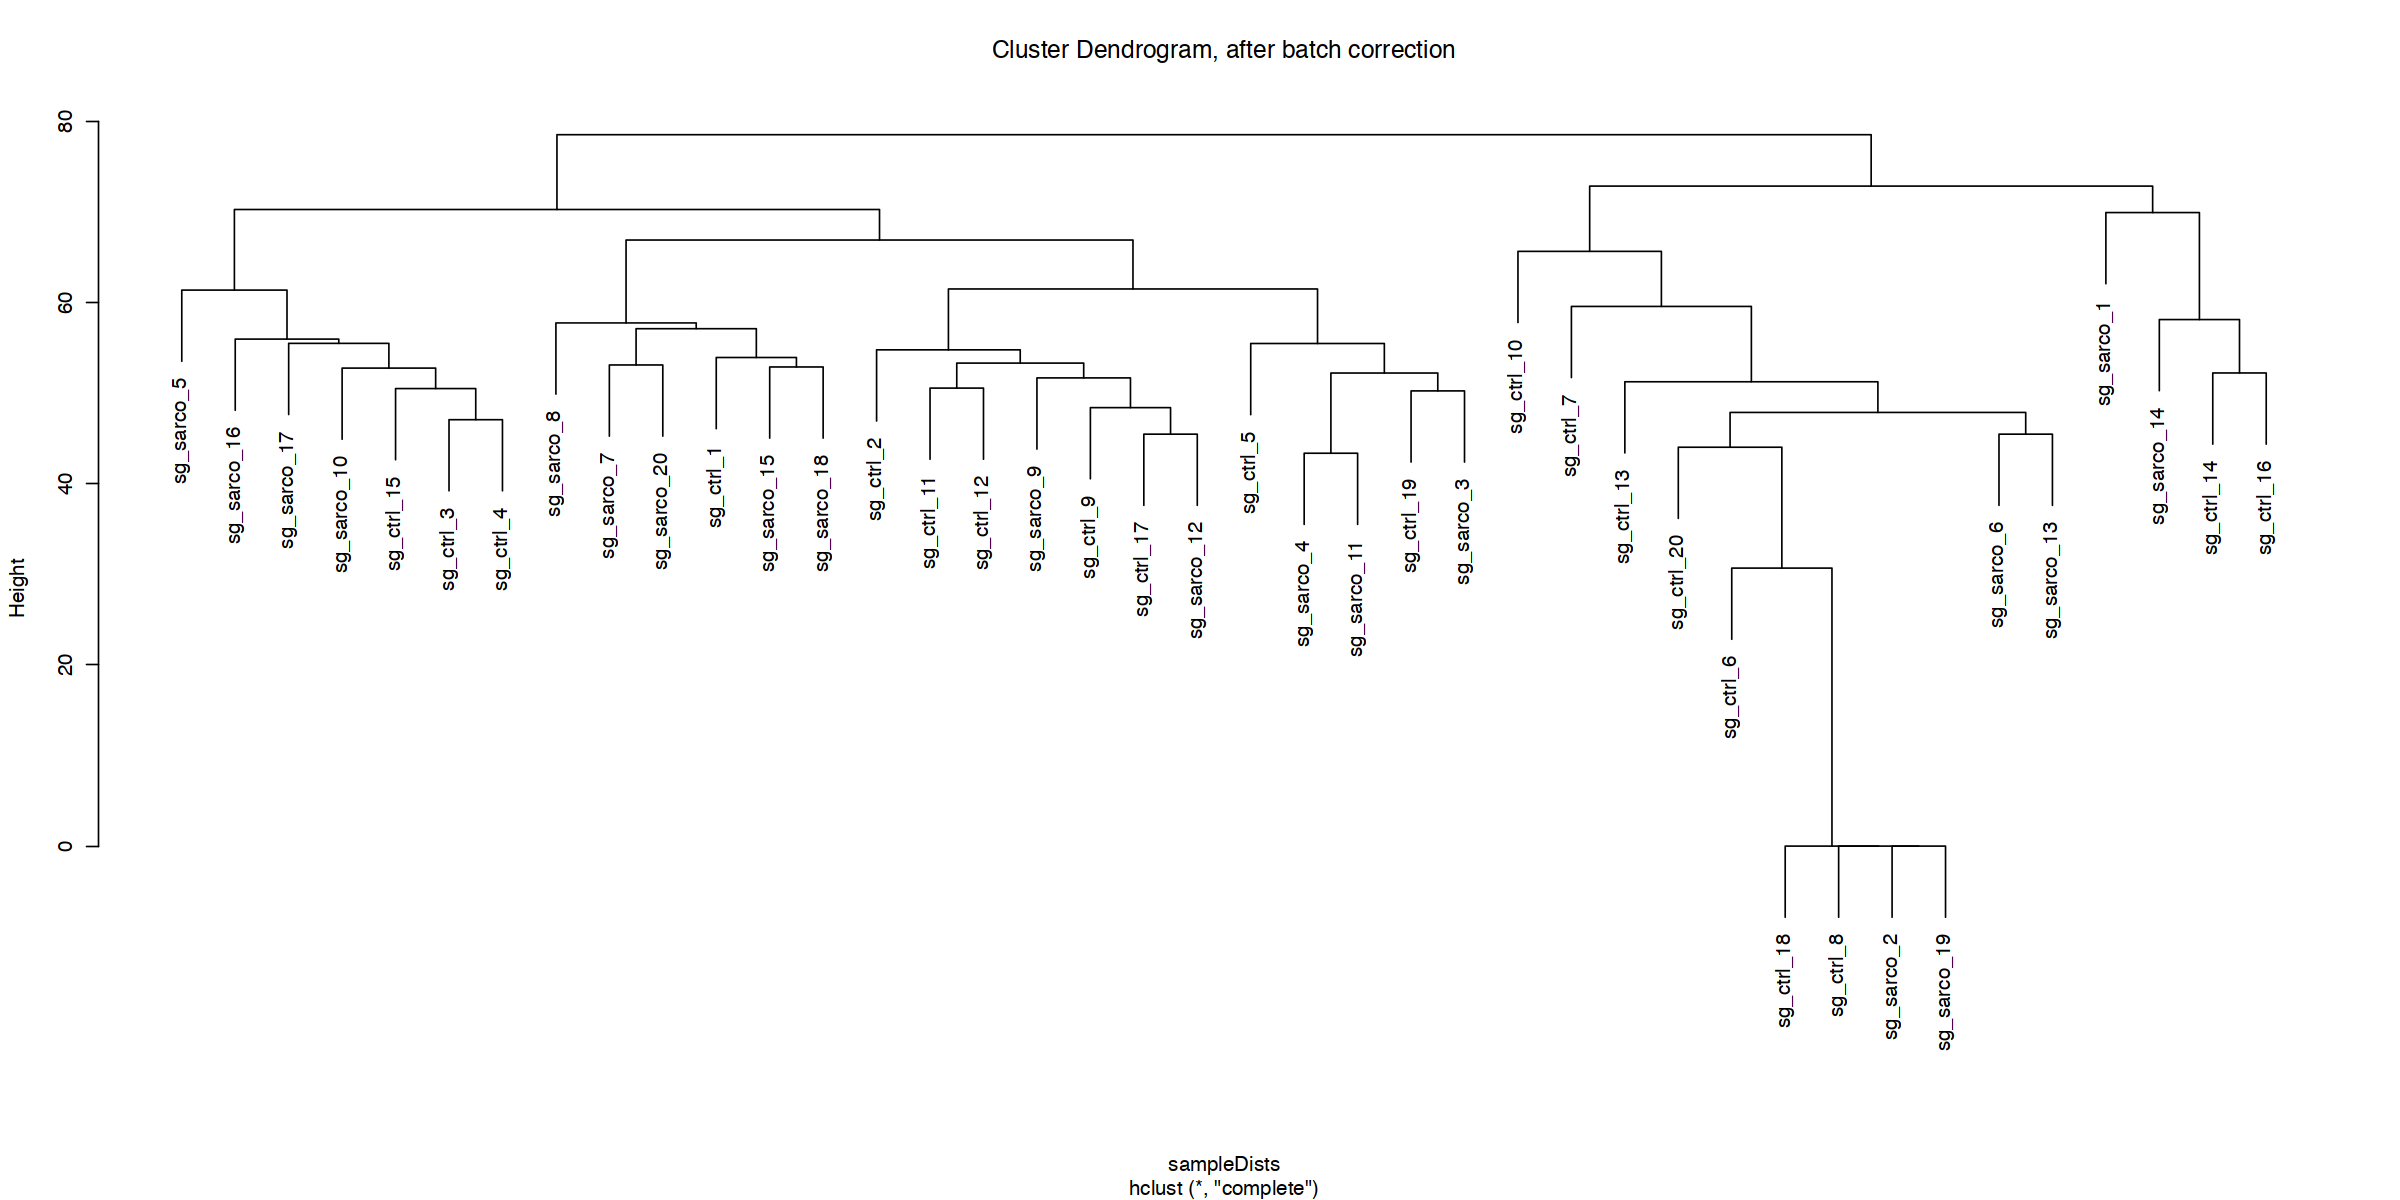

In [44]:
options(repr.plot.height = 10, repr.plot.width = 20)

sampleDists <- dist(t(assay(rld_corrected)))
plot(hclust(sampleDists), main = "Cluster Dendrogram, after batch correction")

This makes absolutely no sense whatsoever. 

In [45]:
## If the directory doesn't exist, create it
if(!dir.exists("../output/")){
  dir.create("../output/")
}

if(!dir.exists("../output/01a_QC_sg/")){
  dir.create("../output/01a_QC_sg/")
}

saveRDS(dds_filt, "../output/01a_QC_sg/dds_quality_control.RDS")
saveRDS(dds_corrected, "../output/01a_QC_sg/dds_corrected.RDS")
#saveRDS(nctpm, "../analysis/output/QC/tpm.RDS")
#saveRDS(ensembl.genes, "../../output/QC/ensembl_genes.RDS")
#saveRDS(hs.gtf.db, "../../output/QC/hs_gtf_db.RDS")
saveRDS(metadata, "../output/01a_QC_sg/metadata.RDS")

### Session Info

In [46]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.6.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] sva_3.46.0                  BiocParallel_1.32.6        
 [3] mgcv_1.8-42                 nlme_3.1-162               
 [5] limma_3.54.2                GEOquery_2.66.0            
 [7] org.Hs.eg.db_3.16.0         clusterProfiler_4.6.2      
 [9] pheatmap_1.0.12             DT_0.28                    
[11] janitor_2.2.0               lubridate_1.9.2            
[13] forcats_1.0.0               stringr_1.5.0              
[15] dplyr_1.1.2                 purrr_1.0.1                
[17] readr_2.1.4              